# [20250410] Transfer Learning

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import time
import os

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [32]:
data_dir = '/content/drive/MyDrive/hymenoptera_data/'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                         data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=2)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'Using {device} device')

Using cuda device


classes: bees ants ants ants


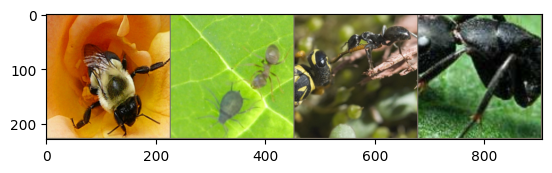

In [33]:
def imshow(inp):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)

inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

print('classes:', ' '.join(class_names[x] for x in classes))
imshow(out)

In [34]:
def train_model(model, criterion, optimizer, num_epochs=25):
  since = time.time()

  best_acc = 0.0

  for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      running_corrects = 0

      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          if phase == 'train':
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    print()
  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  return model


In [35]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')

In [36]:
num_ftrs = model_ft.fc.in_features
print(num_ftrs)

512


In [37]:
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [38]:
model_ft.fc = nn.Linear(in_features=num_ftrs, out_features=2)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=3e-4, momentum=0.9)

In [12]:
model_ft = train_model(model_ft, criterion, optimizer_ft, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5994 Acc: 0.6475
val Loss: 0.2866 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.5525 Acc: 0.7254
val Loss: 0.2145 Acc: 0.9477

Epoch 2/24
----------
train Loss: 0.4588 Acc: 0.7951
val Loss: 0.2092 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.4100 Acc: 0.8115
val Loss: 0.2706 Acc: 0.8954

Epoch 4/24
----------
train Loss: 0.3552 Acc: 0.8443
val Loss: 0.1645 Acc: 0.9608

Epoch 5/24
----------
train Loss: 0.3447 Acc: 0.8361
val Loss: 0.2070 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.2710 Acc: 0.8893
val Loss: 0.1666 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.3628 Acc: 0.8484
val Loss: 0.1920 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3347 Acc: 0.8648
val Loss: 0.1734 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3238 Acc: 0.8566
val Loss: 0.1842 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.3004 Acc: 0.8730
val Loss: 0.1691 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.2376 Acc: 0.9016
val Loss: 0.1608 Acc: 0.9346

Ep

In [21]:
def visualize_model(model, num_images=6):
  was_training = model.training
  model.eval()
  images_so_far = 0
  plt.figure()
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.size()[0]):
        images_so_far += 1
        ax = plt.subplot(num_images//2, 2, images_so_far)
        ax.axis('off')
        ax.set_title(f'True: {class_names[labels[j]]} | Predict: {class_names[labels[j]]}')
        imshow(inputs.cpu().data[j])

        if images_so_far == num_images:
          model.train(mode=was_training)
          return
    model.train(mode=was_training)

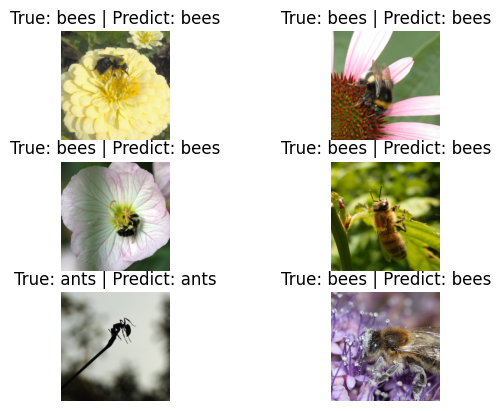

In [22]:
visualize_model(model_ft)

In [26]:
model_fe = models.resnet18(weights='IMAGENET1K_V1')
for param in model_fe.parameters():
  param.requires_grad = False

model_fe.fc = nn.Linear(in_features=num_ftrs, out_features=2)
model_fe.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer_fe = optim.SGD(model_fe.parameters(), lr=3e-4, momentum=0.9)

In [28]:
model_fe = train_model(model_fe, criterion, optimizer_fe, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6521 Acc: 0.5615
val Loss: 0.4213 Acc: 0.8235

Epoch 1/24
----------
train Loss: 0.5152 Acc: 0.7418
val Loss: 0.2750 Acc: 0.9150

Epoch 2/24
----------
train Loss: 0.4120 Acc: 0.8115
val Loss: 0.2904 Acc: 0.8889

Epoch 3/24
----------
train Loss: 0.4396 Acc: 0.8115
val Loss: 0.2540 Acc: 0.9085

Epoch 4/24
----------
train Loss: 0.4208 Acc: 0.7828
val Loss: 0.2243 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.3745 Acc: 0.8361
val Loss: 0.2086 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.4287 Acc: 0.7951
val Loss: 0.1783 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.3524 Acc: 0.8402
val Loss: 0.1768 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.4301 Acc: 0.8115
val Loss: 0.1878 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.4087 Acc: 0.8197
val Loss: 0.2268 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.3380 Acc: 0.8484
val Loss: 0.1705 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.3825 Acc: 0.8156
val Loss: 0.2364 Acc: 0.8954

Ep